In [18]:
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True) 

In [18]:
df_rating = pd.read_csv('title_rating.tsv',delimiter='\t')
df_name = pd.read_csv('name_basic.tsv',delimiter='\t')
df_title = pd.read_csv('title_basic.tsv',delimiter='\t')
df_nt = pd.read_csv('title_principal.tsv',delimiter='\t')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(df_rating.columns)
print(df_name.columns)
print(df_title.columns)
print(df_nt.columns)

Index(['tconst', 'averageRating', 'numVotes'], dtype='object')
Index(['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession',
       'knownForTitles'],
      dtype='object')
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')
Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object')


In [4]:
df_title.titleType.unique()

array(['short', 'movie', 'tvMovie', 'tvSeries', 'tvEpisode', 'tvShort',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

### Data Preparation
準備訓練模型所需資料

In [18]:
cast = df_nt[df_nt['category'].isin(['actor', 'actress'])]
crew = df_nt[~df_nt['category'].isin(['actor', 'actress'])]

In [23]:
cast

,tconst,ordering,nconst,category,job,characters
11,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]"
12,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]"
16,tt0000007,1,nm0179163,actor,\N,\N
17,tt0000007,2,nm0183947,actor,\N,\N
21,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]"
...,...,...,...,...,...,...
36499695,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]"
36499696,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]"
36499697,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]"
36499698,tt9916880,4,nm1052583,actress,\N,"[""Mum"",""Tidy Ted"",""Fang""]"


In [29]:
to_wtv = pd.DataFrame(cast.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']])).reset_index().iloc[:, 1]
to_wtv.head(3)

0    [nm0443482, nm0653042]
1    [nm0179163, nm0183947]
2               [nm0653028]
Name: 0, dtype: object

In [17]:
to_wtv

0                                     [nm0443482, nm0653042]
1                                     [nm0179163, nm0183947]
2                                                [nm0653028]
3                          [nm0063086, nm0183823, nm1309758]
4                                                [nm3692297]
                                 ...                        
3602195         [nm5519557, nm8825009, nm5262613, nm8690065]
3602196         [nm5519557, nm8825009, nm5262613, nm8690065]
3602197         [nm5519557, nm8825009, nm5262613, nm8690065]
3602198      [nm3394271, nm10538650, nm10538646, nm10538647]
3602199    [nm1469295, nm1483166, nm0254176, nm0286175, n...
Name: 0, Length: 3602200, dtype: object

In [7]:
sum([len(to_wtv[i]) for i in range(0,len(to_wtv))]) / len(to_wtv)

4.116993226361668

In [8]:
with open('model/to_wtv.pk','wb+') as f:
    pk.dump(to_wtv,f)

In [16]:
with open('model/to_wtv.pk','rb') as f:
    to_wtv = pk.load(f)

### Word2Vec
先訓練基本模型作為base，並稍微檢視訓練成果

In [ ]:
wtv = Word2Vec(window=10, min_count=5)
wtv.build_vocab(to_wtv)
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=10)
wtv.save("model/word2vec_model")

In [ ]:
wtv = Word2Vec.load("model/word2vec_model")

In [54]:
from IPython.display import HTML, display
from bs4 import BeautifulSoup
import requests

def get_name(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    return soup.select('.header .itemprop')[0].text

def get_image(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    candidates = soup.select('#name-poster')
    return candidates[0].attrs['src'] if candidates else 'https://m.media-amazon.com/images/G/01/imdb/images/nopicture/medium/name-2135195744._CB466677935_.png'

def render_person(id):
    name = get_name(id)
    picture = get_image(id)
    return f"""
    <div style="width: 150px; text-align: center">
        <h4 style='margin-top: -5px'>{name}</h4>
        <div style='font-size:75%; margin-bottom: 5px'>{id}</div>
        <a href="https://www.imdb.com/name/{id}" target="_blank">
            <img style="width: 100px; display: block; margin-left: auto; margin-right: auto;" src="{picture}"/>
        </a>
    </div>
    """

def show_similars(model,id, n=10):
    if id in model.wv: 
        display(HTML(render_person(id)))
    renders = []
    for similar_id, score in model.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
        )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

In [ ]:
show_similars(wtv,'nm0192505')

In [ ]:
show_similars(wtv,'nm0425005')

In [ ]:
show_similars(wtv,'nm0366389')

In [ ]:
show_similars(wtv,'nm0695435')

In [29]:
show_similars(wtv,'nm2225369')

In [30]:
show_similars(wtv,'nm0000375')

In [31]:
show_similars(wtv,'nm0424060')

### Find Best Parameter
開始對不同參數進行tuning

In [53]:
def transform(model,dim=100):
    movie_act = pd.DataFrame({'tconst': cast['tconst'].unique(), 'nconst': to_wtv})
    means = []
    for names in movie_act['nconst'].tolist():
        vec = np.zeros((len(names),dim))
        cnt = 0

        for name in names:
            try:
                vec[cnt] = model.wv[name]
                cnt += 1
            except:
                pass

        for i in range(vec.shape[0]-cnt):
            vec = np.delete(vec, -1, 0)

        if vec.shape[0] > 0:
            mean_vec = np.mean(vec,axis=0)
        else:
            mean_vec = pd.NA

        means.append(mean_vec)
    movie_act['mean'] = means
    
    movie_vec = pd.merge(movies['tconst'],movie_act,on='tconst',how='left')
    x2 = pd.concat([x,y],axis=1)
    x2['mean'] = movie_vec['mean']
    x2.dropna(inplace=True)
    x2 = x2.reset_index().drop(['index'],axis=1)
    y2 = x2['averageRating']
    
    vecdim = ['actdim%d'%i for i in range(1,dim+1)]
    x_act = pd.DataFrame(data=x2['mean'].tolist(),columns=vecdim)
    
    x2 = x2.drop(['mean','averageRating'],axis=1)
    
    return x2,x_act,y2

#### Epoch

In [321]:
epochs = [1,10,50,100,200]
scores = np.zeros((3,5))

for ii,i in enumerate(epochs):
    wtv = Word2Vec(window=10, min_count=5)
    wtv.build_vocab(to_wtv)
    wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=i)
    x2,x_act,y2 = transform(wtv)
    
    print('Epoch = %d'%i)
    print('Only Other Features: x2')
    reg = LinearRegression().fit(x2,y2)
    a = reg.score(x2,y2)
    print(a)
    
    print("-----")
    print('Only Actor Vectors: x_act')
    reg = LinearRegression().fit(x_act,y2)
    b = reg.score(x_act,y2)
    print(b)
    
    print("-----")
    print('Combine: x2_act')
    x2_act = pd.concat([x2,x_act],axis=1)
    reg = LinearRegression().fit(x2_act,y2)
    c = reg.score(x2_act,y2)
    print(c)
    print("=====")
    
    scores[0][ii] = a
    scores[1][ii] = b
    scores[2][ii] = c

Epoch = 1
Only Other Features: x2
0.21094122348464217
-----
Only Actor Vectors: x_act
0.007500443182337335
-----
Combine: x2_act
0.21505186354533234
=====
Epoch = 10
Only Other Features: x2
0.21094122348464217
-----
Only Actor Vectors: x_act
0.07075190886261462
-----
Combine: x2_act
0.24396112467730602
=====
Epoch = 50
Only Other Features: x2
0.21094122348464217
-----
Only Actor Vectors: x_act
0.1176536755534564
-----
Combine: x2_act
0.2601097358000357
=====
Epoch = 100
Only Other Features: x2
0.21094122348464217
-----
Only Actor Vectors: x_act
0.12156712579348172
-----
Combine: x2_act
0.260946783133317
=====
Epoch = 200
Only Other Features: x2
0.21094122348464217
-----
Only Actor Vectors: x_act
0.12323938313108884
-----
Combine: x2_act
0.2598417503013557
=====


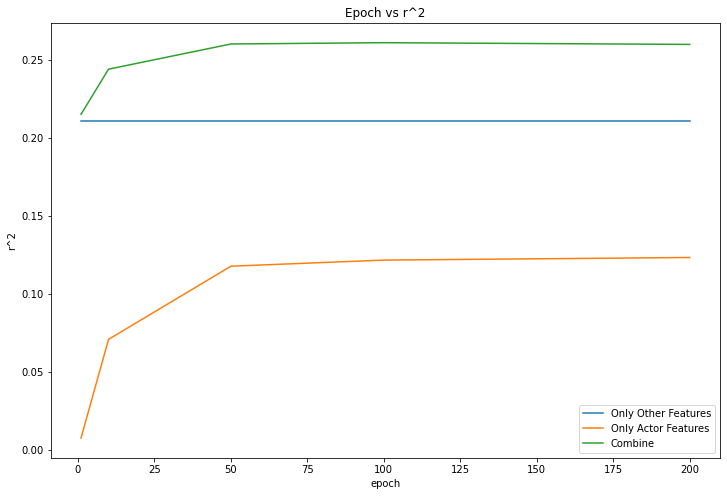

In [322]:
plt.figure(figsize=(12,8))
plt.plot(epochs, scores[0], label="Only Other Features")
plt.plot(epochs, scores[1], label="Only Actor Features")
plt.plot(epochs, scores[2], label="Combine")
plt.xlabel("epoch")
plt.ylabel('r^2')
plt.legend()
plt.title("Epoch vs r^2")
plt.show()

#### Min Count

In [323]:
counts = [1,5,10,25,40]
scores = np.zeros((3,5))

for ii,i in enumerate(counts):
    wtv = Word2Vec(window=10, min_count=i)
    wtv.build_vocab(to_wtv)
    wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=100)
    x2,x_act,y2 = transform(wtv)
    
    print('Min Count = %d'%i)
    print('Only Other Features: x2')
    reg = LinearRegression().fit(x2,y2)
    a = reg.score(x2,y2)
    print(a)
    
    print("-----")
    print('Only Actor Vectors: x_act')
    reg = LinearRegression().fit(x_act,y2)
    b = reg.score(x_act,y2)
    print(b)
    
    print("-----")
    print('Combine: x2_act')
    x2_act = pd.concat([x2,x_act],axis=1)
    reg = LinearRegression().fit(x2_act,y2)
    c = reg.score(x2_act,y2)
    print(c)
    print("=====")
    
    scores[0][ii] = a
    scores[1][ii] = b
    scores[2][ii] = c

Min Count = 1
Only Other Features: x2
0.21833812487405646
-----
Only Actor Vectors: x_act
0.10125991078431429
-----
Combine: x2_act
0.25889869773069685
=====
Min Count = 5
Only Other Features: x2
0.21094122348464217
-----
Only Actor Vectors: x_act
0.12163382088217467
-----
Combine: x2_act
0.2603222936849049
=====
Min Count = 10
Only Other Features: x2
0.21178427575831915
-----
Only Actor Vectors: x_act
0.12258835687506253
-----
Combine: x2_act
0.2585865636127519
=====
Min Count = 25
Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.1205936684902904
-----
Combine: x2_act
0.2605007793451678
=====
Min Count = 40
Only Other Features: x2
0.21485010746257516
-----
Only Actor Vectors: x_act
0.11349006697702313
-----
Combine: x2_act
0.2586177631321339
=====


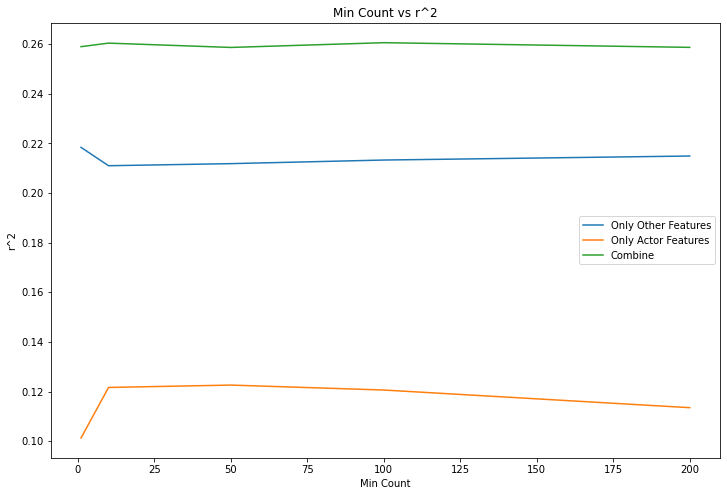

In [324]:
plt.figure(figsize=(12,8))
plt.plot(epochs, scores[0], label="Only Other Features")
plt.plot(epochs, scores[1], label="Only Actor Features")
plt.plot(epochs, scores[2], label="Combine")
plt.xlabel("Min Count")
plt.ylabel('r^2')
plt.legend()
plt.title("Min Count vs r^2")
plt.show()

#### Algorithms

In [325]:
wtv = Word2Vec(window=10, min_count=25,sg=0)
wtv.build_vocab(to_wtv)
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=100)
x2,x_act,y2 = transform(wtv)

print('Only Other Features: x2')
reg = LinearRegression().fit(x2,y2)
a = reg.score(x2,y2)
print(a)

print("-----")
print('Only Actor Vectors: x_act')
reg = LinearRegression().fit(x_act,y2)
b = reg.score(x_act,y2)
print(b)

print("-----")
print('Combine: x2_act')
x2_act = pd.concat([x2,x_act],axis=1)
reg = LinearRegression().fit(x2_act,y2)
c = reg.score(x2_act,y2)
print(c)
print("=====")

Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.11968391033429715
-----
Combine: x2_act
0.2599728631722511
=====


In [326]:
wtv = Word2Vec(window=10, min_count=25,sg=1)
wtv.build_vocab(to_wtv)
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=100)
x2,x_act,y2 = transform(wtv)

print('Only Other Features: x2')
reg = LinearRegression().fit(x2,y2)
a = reg.score(x2,y2)
print(a)

print("-----")
print('Only Actor Vectors: x_act')
reg = LinearRegression().fit(x_act,y2)
b = reg.score(x_act,y2)
print(b)

print("-----")
print('Combine: x2_act')
x2_act = pd.concat([x2,x_act],axis=1)
reg = LinearRegression().fit(x2_act,y2)
c = reg.score(x2_act,y2)
print(c)
print("=====")

Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.11592816333278255
-----
Combine: x2_act
0.2580499187341694
=====


#### Dimensions

In [ ]:
dims = [100,300,500]
scores = np.zeros((3,5))

for ii,i in enumerate(dims):
    wtv = Word2Vec(window=10, min_count=25,vector_size=i)
    wtv.build_vocab(to_wtv)
    wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=100)
    x2,x_act,y2 = transform(wtv,i)
    
    print('Vector Size = %d'%i)
    print('Only Other Features: x2')
    reg = LinearRegression().fit(x2,y2)
    a = reg.score(x2,y2)
    print(a)
    
    print("-----")
    print('Only Actor Vectors: x_act')
    reg = LinearRegression().fit(x_act,y2)
    b = reg.score(x_act,y2)
    print(b)
    
    print("-----")
    print('Combine: x2_act')
    x2_act = pd.concat([x2,x_act],axis=1)
    reg = LinearRegression().fit(x2_act,y2)
    c = reg.score(x2_act,y2)
    print(c)
    print("=====")
    
    scores[0][ii] = a
    scores[1][ii] = b
    scores[2][ii] = c

Vector Size = 100
Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.11862477010759942
-----
Combine: x2_act
0.2602017292291867
=====
Vector Size = 300
Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.1421104295286879
-----
Combine: x2_act
0.27462379477321597
=====


In [20]:
wtv = Word2Vec(window=10, min_count=25,vector_size=500)
wtv.build_vocab(to_wtv)
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=100)
x2,x_act,y2 = transform(wtv,500)

print('Vector Size = %d'%500)
print('Only Other Features: x2')
reg = LinearRegression().fit(x2,y2)
a = reg.score(x2,y2)
print(a)

print("-----")
print('Only Actor Vectors: x_act')
reg = LinearRegression().fit(x_act,y2)
b = reg.score(x_act,y2)
print(b)

print("-----")
print('Combine: x2_act')
x2_act = pd.concat([x2,x_act],axis=1)
reg = LinearRegression().fit(x2_act,y2)
c = reg.score(x2_act,y2)
print(c)
print("=====")

Vector Size = 500
Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.1590692029181604
-----
Combine: x2_act
0.2869158731466006
=====


### Final W2V

In [54]:
wtv = Word2Vec(window=10, min_count=25,vector_size=300)
wtv.build_vocab(to_wtv)
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=300)
x2,x_act,y2 = transform(wtv,300)

print('Only Other Features: x2')
reg = LinearRegression().fit(x2,y2)
a = reg.score(x2,y2)
print(a)

print("-----")
print('Only Actor Vectors: x_act')
reg = LinearRegression().fit(x_act,y2)
b = reg.score(x_act,y2)
print(b)

print("-----")
print('Combine: x2_act')
x2_act = pd.concat([x2,x_act],axis=1)
reg = LinearRegression().fit(x2_act,y2)
c = reg.score(x2_act,y2)
print(c)
print("=====")

Only Other Features: x2
0.21323265439793115
-----
Only Actor Vectors: x_act
0.14191460136063816
-----
Combine: x2_act
0.27276571353403734
=====


In [18]:
wtv.save("model/bestw2v_model")

In [44]:
wtv = Word2Vec.load("model/bestw2v_model")

### BERT

In [3]:
import pickle as pk
import numpy as np
import pandas as pd
with open('/home/hsien/110/sta/final_pkfile/imdb_df_genres_title_cgname.pk','rb') as f:
    movies = pk.load(f)
movies

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,tt0149295,movie,Il trionfo di Maciste,Il trionfo di Maciste,0,1961,\N,88.0,"[Action, Adventure, Drama]",4.2,...,0,0,0,0,0,0,0,0,0,0
1,tt0743141,tvEpisode,The Jed Polke Story,The Jed Polke Story,0,1961,\N,60.0,[Western],8.2,...,0,0,0,0,0,0,0,0,0,1
2,tt0056099,movie,Information Received,Information Received,0,1961,\N,77.0,[Crime],5.8,...,0,0,0,0,0,0,0,0,0,0
3,tt0274612,movie,The Red Vase,Kizil vazo,0,1961,\N,97.0,[Drama],5.9,...,0,0,0,0,0,0,0,0,0,0
4,tt0743144,tvEpisode,The Jenna Douglas Story,The Jenna Douglas Story,0,1961,\N,60.0,[Western],7.7,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203516,tt7159616,movie,Puppy Swap Love Unleashed,Puppy Swap Love Unleashed,0,2019,\N,90.0,[Family],5.8,...,0,0,0,0,0,0,0,0,0,0
203517,tt7158904,movie,Blood Myth,Blood Myth,0,2019,\N,81.0,[Horror],3.0,...,0,0,0,0,0,0,0,0,0,0
203518,tt7156898,movie,County Lines,County Lines,0,2019,\N,90.0,[Drama],8.4,...,0,0,0,0,0,0,0,0,0,0
203519,tt7216068,movie,See You Soon,See You Soon,0,2019,\N,107.0,"[Drama, Romance]",4.7,...,0,0,1,0,0,0,0,0,0,0


In [5]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased")

names = movies['primaryTitle'].tolist()
result = np.zeros((len(names),768))
for i in range(len(names)):
    inputs = tokenizer(names[i], return_tensors="pt")
    outputs = model(**inputs)
    result[i] = outputs[1].detach().numpy()
    if i % 10000 == 0:
        print("Progress: %d / %d"%(i,(len(names))))
df_bert = pd.DataFrame(result,columns = ['bertdim%d'%i for i in range(1,769)])
df_bert

,bertdim1,bertdim2,bertdim3,bertdim4,bertdim5,bertdim6,bertdim7,bertdim8,bertdim9,bertdim10,...,bertdim759,bertdim760,bertdim761,bertdim762,bertdim763,bertdim764,bertdim765,bertdim766,bertdim767,bertdim768
0,-0.808446,0.531357,0.999978,-0.997249,0.976660,0.736699,0.991883,-0.946218,-0.982858,-0.718163,...,0.816118,-0.137228,0.208553,-0.397403,-0.284671,-0.074878,-0.422092,0.999994,-0.119906,0.994673
1,-0.801082,0.600533,0.999987,-0.997582,0.981994,0.743360,0.987109,-0.899205,-0.991019,-0.611979,...,0.834444,0.298309,-0.387350,-0.168412,0.090523,0.054783,-0.463617,0.999997,0.134567,0.997376
2,-0.799335,0.539186,0.999974,-0.995560,0.969992,0.332953,0.984201,-0.864574,-0.977825,-0.721972,...,0.854814,0.032401,0.034883,0.108208,0.007342,-0.051844,-0.338245,0.999992,0.464673,0.990535
3,-0.791939,0.533764,0.999982,-0.994044,0.982556,0.138356,0.984055,-0.778561,-0.970028,-0.755540,...,0.814216,0.088590,-0.279346,0.293751,-0.019581,0.437237,-0.456628,0.999996,0.661209,0.989308
4,-0.794213,0.590708,0.999986,-0.997450,0.983491,0.744515,0.989851,-0.892761,-0.991016,-0.663410,...,0.850816,0.343397,-0.252299,-0.015784,0.104728,0.055120,-0.494890,0.999997,0.094556,0.996966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203516,-0.829577,0.614411,0.999984,-0.997057,0.972475,0.645951,0.996290,-0.871867,-0.990296,-0.761941,...,0.917815,0.122077,0.294425,0.034675,0.034758,-0.002479,-0.384835,0.999995,0.058297,0.995574
203517,-0.705849,0.484358,0.999938,-0.996463,0.967698,0.891910,0.986233,-0.986882,-0.978663,-0.607660,...,0.706264,-0.206130,0.631617,-0.528963,-0.414147,-0.414602,-0.323906,0.999985,-0.568291,0.995338
203518,-0.816883,0.569761,0.999960,-0.994995,0.973453,0.752618,0.983180,-0.923110,-0.989151,-0.746955,...,0.901440,0.038414,0.048621,-0.400591,0.182601,0.135849,-0.447408,0.999987,-0.158210,0.992613
203519,-0.807530,0.520048,0.999977,-0.997869,0.978094,0.890757,0.993739,-0.967993,-0.992112,-0.731037,...,0.850995,-0.126043,0.250805,-0.217400,-0.156514,-0.238235,-0.345735,0.999994,-0.366782,0.997008


In [6]:
with open('model/df_bert.pk','wb+') as f:
    pk.dump(df_bert,f)

In [7]:
with open('model/df_bert.pk','rb') as f:
    df_bert = pk.load(f)

#### Dimension Reduction

In [19]:
wtv = Word2Vec.load("model/bestw2v_model")

In [19]:
namesinwtv = list(wtv.wv.key_to_index.keys())
vecs = np.zeros((len(namesinwtv),300))
for i,j in enumerate(namesinwtv):
    vecs[i] = wtv.wv[j]
df_vecs = pd.DataFrame(data=vecs,columns=['actdim%d'%(k+1) for k in range(300)])
df_vecs['nid'] = namesinwtv

In [36]:
nid = df_name['nconst']
names = df_name['primaryName']
zip_iterator = zip(nid, names)
namedict = dict(zip_iterator)
def trygetname(i):
    try:
        return namedict[i]
    except:
        return get_name(i)
df_vecs['name'] = [trygetname(i) for i in df_vecs['nid']]

In [37]:
df_vecs

,actdim1,actdim2,actdim3,actdim4,actdim5,actdim6,actdim7,actdim8,actdim9,actdim10,...,actdim293,actdim294,actdim295,actdim296,actdim297,actdim298,actdim299,actdim300,nid,name
0,0.3934,-0.7246,0.3937,-0.3019,0.1518,-0.1869,-0.5549,-1.3651,0.3845,0.7516,...,0.2435,0.4268,-0.4521,0.4413,0.1323,0.2416,0.1439,-0.3189,nm10120013,Sameera Sherief
1,-0.1794,0.1344,0.9647,-1.4697,-0.0592,0.4343,1.0161,-0.3960,0.7794,1.3940,...,-1.9479,-1.3254,1.1152,1.0347,0.5053,-1.3992,-0.4574,-1.1165,nm0151534,Sudha Chandran
2,0.0505,-1.6816,0.3232,0.1675,-1.7351,1.1017,0.8716,-0.1145,-0.8166,1.1188,...,-0.4929,0.6707,-1.7575,-2.2117,-0.8855,-2.3399,0.9864,0.7962,nm0192504,Francisco Cuoco
3,-0.2572,-2.0932,-0.6245,1.0803,-2.3154,0.0648,-0.4783,-0.2144,-0.8842,1.9520,...,-1.8980,-1.5371,0.2474,-1.7884,0.1307,0.5681,-0.5557,-1.2468,nm0555829,Claudio Marzo
4,0.5877,-0.8777,0.3108,-2.4112,0.3106,0.5756,-1.1145,0.4796,2.3461,0.5509,...,0.8624,0.0961,-0.1326,-0.5098,0.3610,1.0778,-0.0955,0.6426,nm0525123,Luz Stella Luengas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91260,0.4434,-0.4928,-0.0498,-0.2588,0.0315,-0.0212,-0.1862,0.0042,0.3785,-0.1410,...,-0.3267,0.1852,-0.0269,-0.0515,-0.3199,0.0380,-0.0644,0.1394,nm0604324,Lisa Moretti
91261,0.2212,-0.3266,-0.1233,-0.1199,-0.2560,0.3973,-0.8988,0.1441,-0.2873,0.0219,...,0.1342,0.0393,0.0930,-0.0046,-0.0910,0.5510,0.1782,-0.2866,nm0642578,Stephen O'Rourke
91262,0.2308,0.3096,-0.1966,0.2632,-0.2069,0.3617,-0.3134,-0.2818,0.3237,-0.0736,...,-0.1789,0.2465,-0.0773,0.2142,-0.5019,-0.1849,0.4442,0.2305,nm0375437,Trudy Hellier
91263,-0.2175,0.0410,0.2171,-0.1686,0.4192,0.2869,-0.5363,-0.2605,0.3500,0.1598,...,-0.0130,0.2099,0.0412,0.3006,0.4780,-0.0684,0.3379,0.0928,nm2814032,Mila Montañez


In [2]:
import plotly
import plotly.express as px
from sklearn.manifold import TSNE

In [ ]:
np.random.seed(42)
seed = np.random.rand(df_vecs.shape[0],2)
tsne_cos = TSNE(n_components=2, metric='cosine',n_jobs=-1,init=seed,square_distances=True)
dep_tsne_jac= tsne_cos.fit_transform(df_vecs.drop(['nid','name'],axis=1))
tsne_cos_df = pd.DataFrame(dep_tsne_cos)
tsne_cos_df['actor_name'] = df_vecs['name']

In [ ]:
with open('model/tsne_cos_df.pk','wb+') as f:
    pk.dump(tsne_cos_df,f)

In [4]:
with open('model/tsne_cos_df.pk','rb') as f:
    tsne_cos_df = pk.load(f)

In [11]:
test_name = 'John David Washington'
x_test = tsne_cos_df[tsne_cos_df['actor_name'] == test_name][0].values[0]
y_test = tsne_cos_df[tsne_cos_df['actor_name'] == test_name][1].values[0]
print(x_test, y_test)

9.789059536512301 1.0701893835130256


In [12]:
tar_name = 'Dwayne Johnson'
x_tar = tsne_cos_df[tsne_cos_df['actor_name'] == tar_name][0].values[0]
y_tar = tsne_cos_df[tsne_cos_df['actor_name'] == tar_name][1].values[0]
print(x_tar, y_tar)

9.736814092426075 0.975122970812483


In [15]:
xpos,ypos = x_tar,y_tar
shift = 1
xup,yup,xdown,ydown = xpos+shift,ypos+shift,xpos-shift,ypos-shift
tsne_small =  tsne_cos_df[(tsne_cos_df[0] < xup) & (tsne_cos_df[0] > xdown) & (tsne_cos_df[1] < yup) & (tsne_cos_df[1] > ydown)]

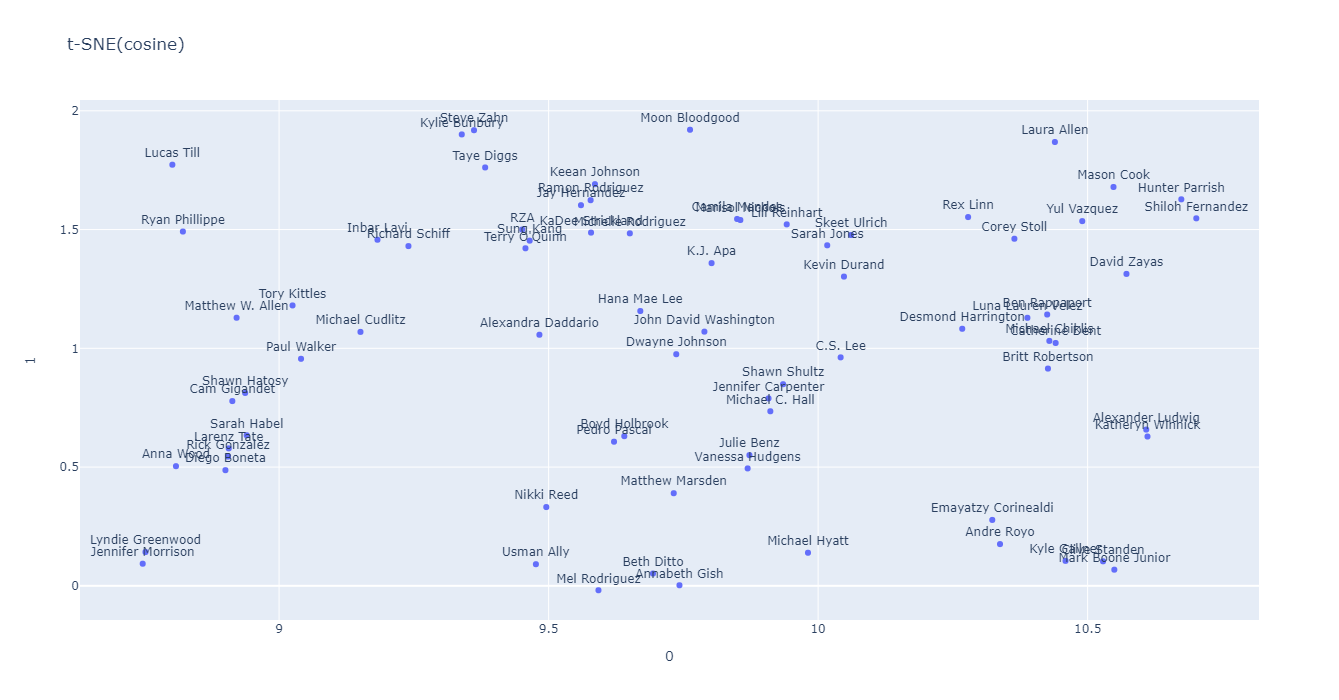

In [16]:
fig = px.scatter(tsne_small,x=0, y=1,title='t-SNE(cosine)',text='actor_name')
fig.update_layout(height=700, width=1000)
fig.update_layout(font_size=12)
fig.update_traces(marker={'size':6},textposition='top center')
fig.show()

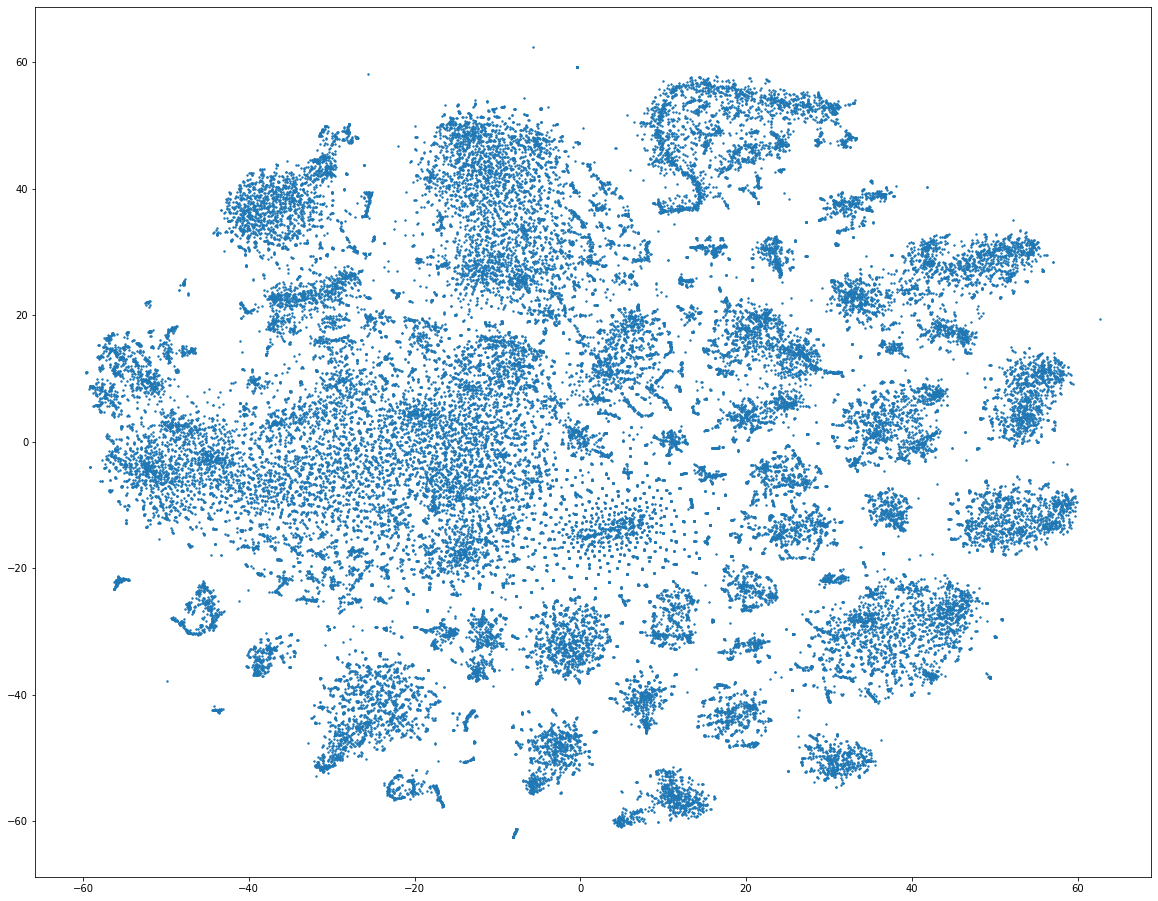

In [51]:
plt.figure(figsize=(20,16))
plt.scatter(tsne_cos_df[0],tsne_cos_df[1],s=2)
plt.show()